In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/NBA Project/NBA_Dataset.csv'

import pandas as pd
data = pd.read_csv(file_path) #file name is here

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# check null values
data.isnull().sum()

# fill null with 0
data = data.fillna(0)

In [ ]:
# define mvp for each season
mvps = data.groupby('season').max('award_share')

# add mvp column to the dataframe
mvps["mvp"] = True

data = data.merge(mvps[["award_share", "mvp"]], on = ["season", "award_share"],
                  how = "left")
data["mvp"] = data["mvp"].fillna(False)

In [ ]:
data.head()

,season,player,pos,age,team_id,g,gs,mp_per_g,fg_per_g,fga_per_g,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,mvp
0,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
1,1982,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,0.144,1.4,2.2,3.6,3.4,0.000,3.45,3.05,0.561,False
2,1982,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,0.061,2.3,-1.6,0.7,1.0,0.000,-4.43,-4.48,0.341,False
3,1982,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,0.042,-3.7,1.0,-2.7,-0.1,0.000,6.38,6.35,0.768,False
4,1982,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,0.115,1.4,-1.3,0.1,1.1,0.000,6.38,6.35,0.768,False


<ipython-input-67-b359f5320430>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


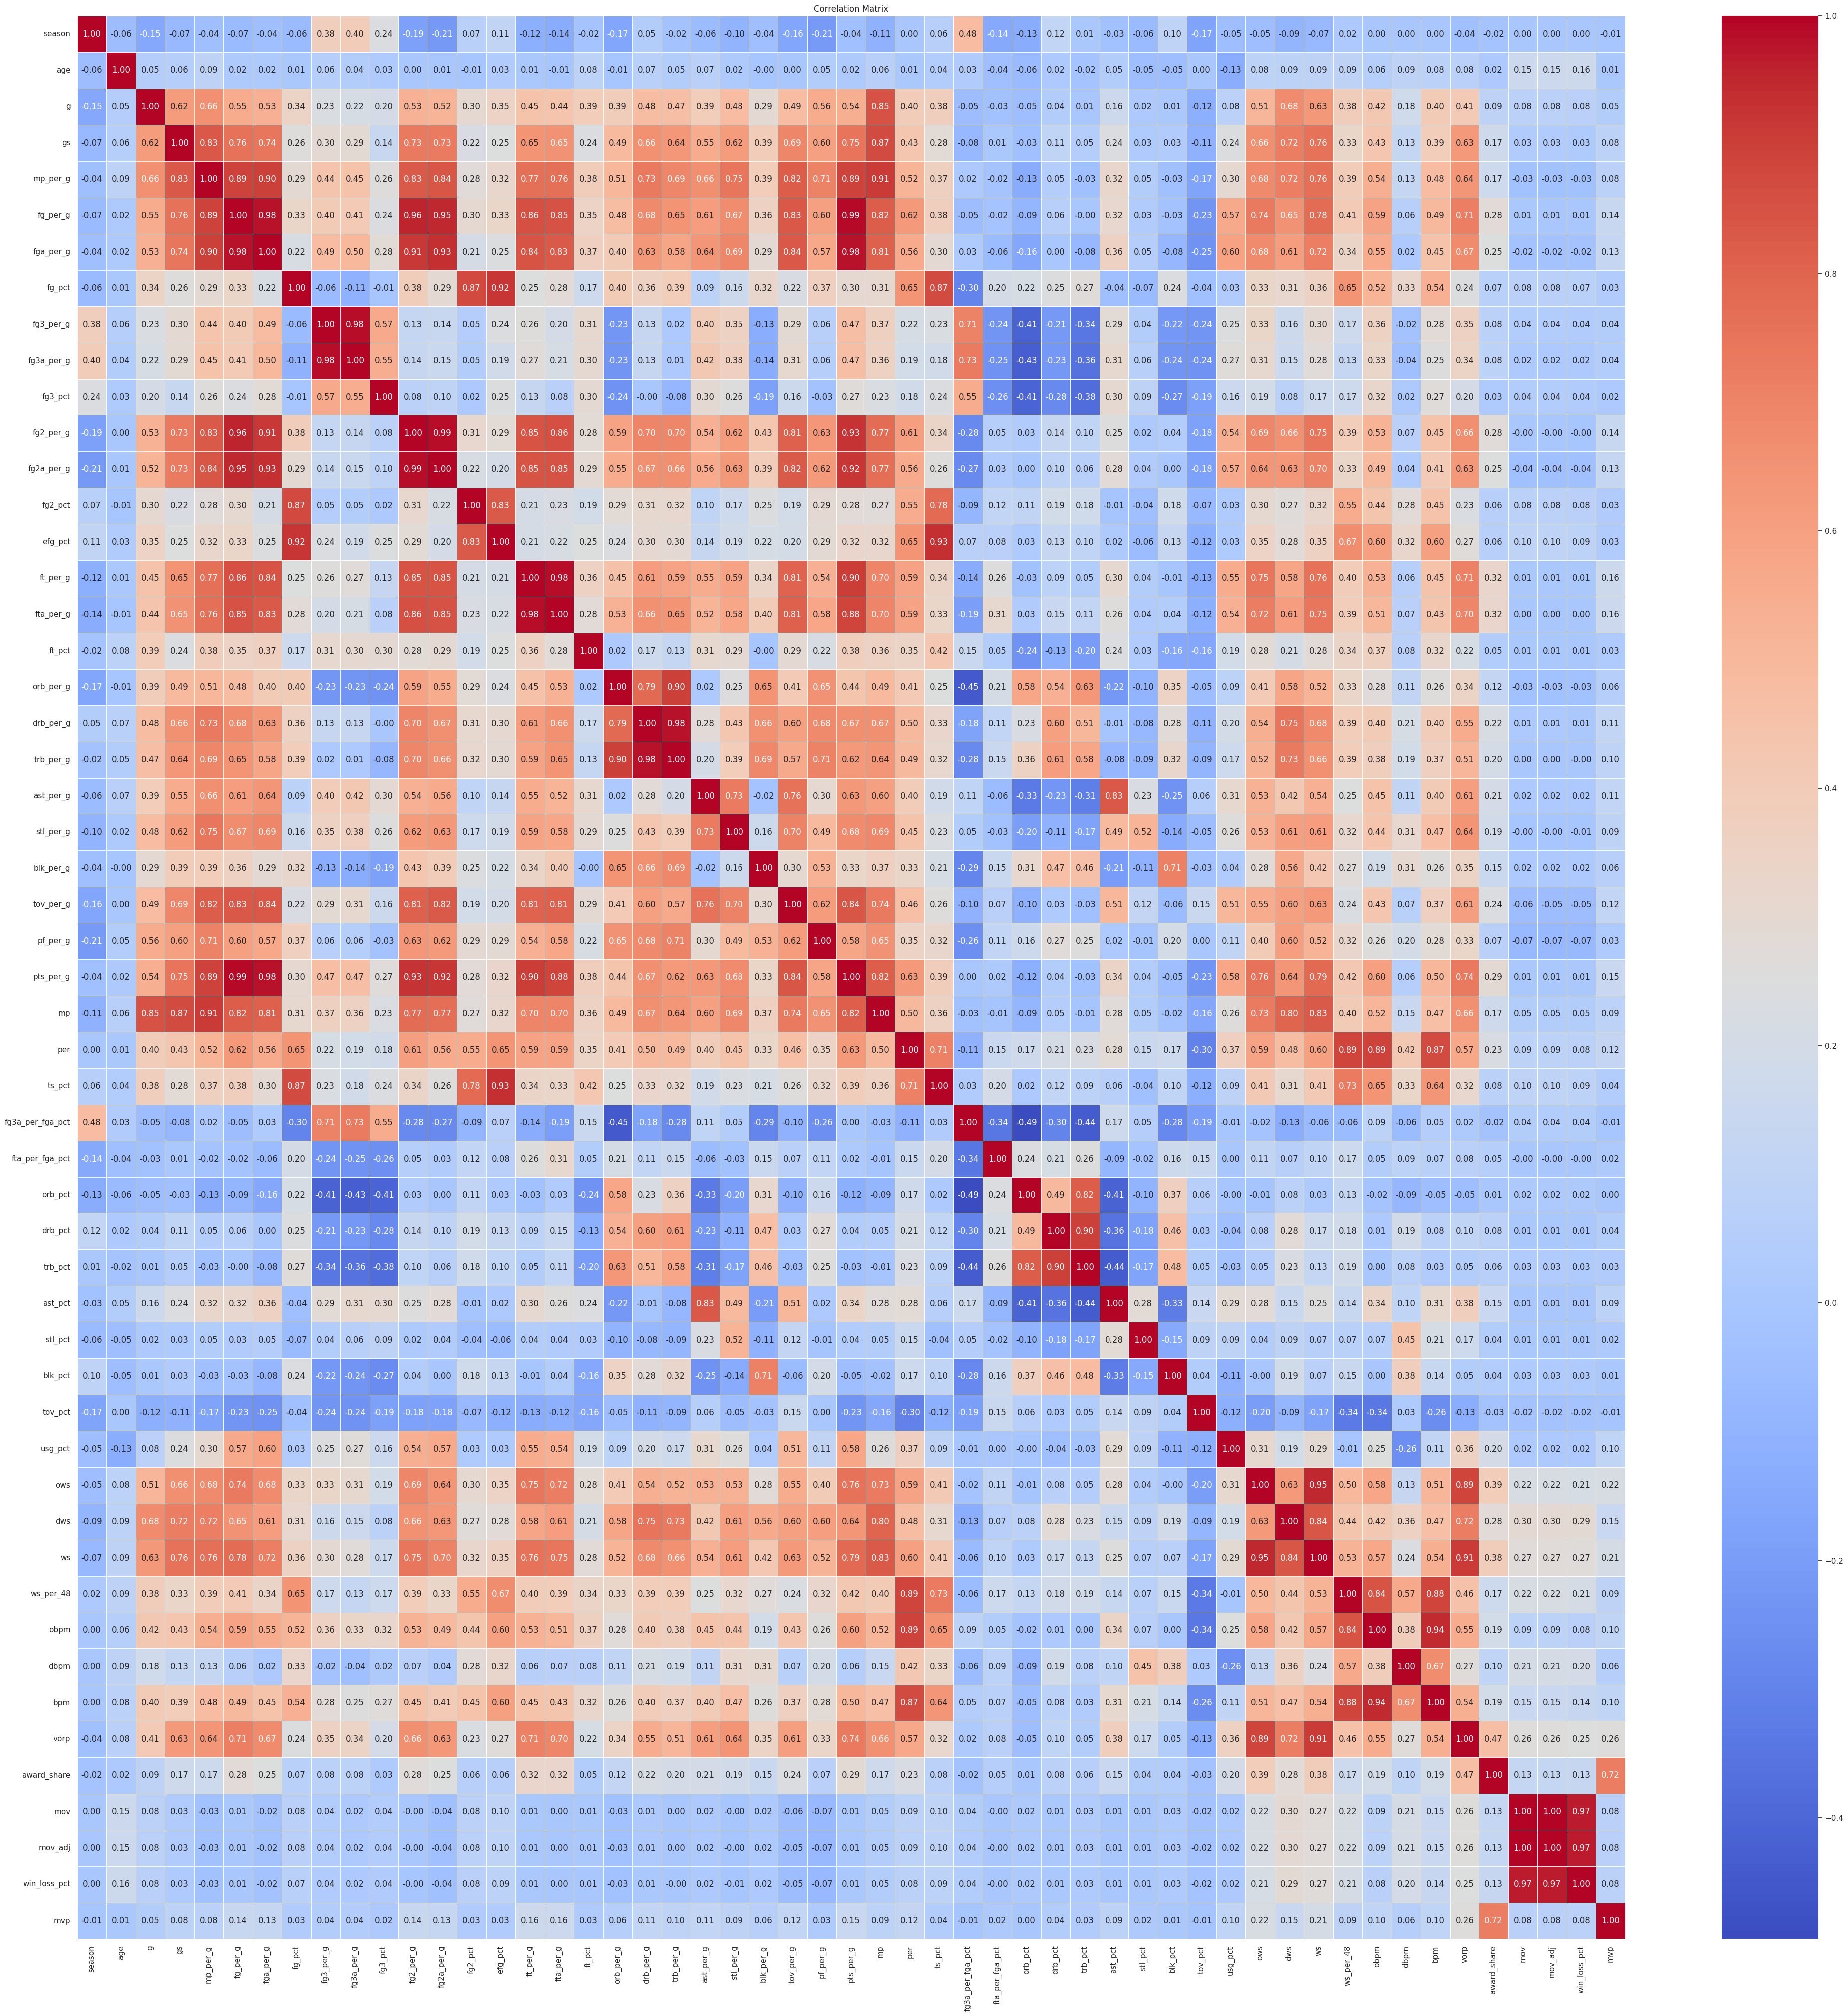

In [ ]:
corr = data.corr()

plt.figure(figsize=(50, 50))  # Optional: Adjusts the size of the plot
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# drop some of the columns that are derived from the others
data = data.drop(columns = ["fg_per_g", "fg3_per_g", "fg2_per_g", "ft_per_g",
                            "efg_pct", "ts_pct", "pos", "team_id", "g",
                            "fg_per_g", "fga_per_g", "fg3a_per_g", "fg2a_per_g",
                            "fta_per_g", "orb_per_g", "drb_per_g", "mp", "fg3a_per_fga_pct",
                            "fta_per_fga_pct"],
                 axis = 1)


In [ ]:
data.head()

mvp_data = data[data['mvp'] == True]

It doesn't make sense to use all players from all past 20 years to train a model, so we need to reduce some of them to make our model more reasonable, and the reduction is all based on some logical thinking - so it can reduce those ones who have 0 chance to win an MVP.

So let's set up some ground rules.

1. Player must have played at least 20 games.
2. Player must have played at least 20 minutes per game.
3. Player must have averaged more than 10 point per game.

Below are the code that explain why setting these ground rules.

In [ ]:
# points per game
mvp_data['pts_per_g'].mean()

27.0

In [ ]:
# minutes per game
mvp_data['mp_per_g'].mean()

37.363414634146345

In [ ]:
# games played
mvp_data['gs'].mean()

77.1951219512195

In [ ]:
# eliminate players that do not satisfy rules

data = data[data['gs'] > 20]
data = data[data['mp_per_g'] > 20]
data = data[data['pts_per_g'] > 20]

data.head()

,season,player,age,gs,mp_per_g,fg_pct,fg3_pct,fg2_pct,ft_pct,trb_per_g,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,mvp
0,1982,Kareem Abdul-Jabbar,34,76,35.2,0.579,0.000,0.580,0.706,8.7,...,0.192,3.8,1.2,5.0,4.7,0.045,4.87,4.37,0.695,False
14,1982,Larry Bird,25,58,38.0,0.503,0.212,0.514,0.863,10.9,...,0.205,4.4,2.3,6.6,6.4,0.588,6.38,6.35,0.768,False
60,1982,Adrian Dantley,26,81,39.8,0.570,0.333,0.570,0.792,6.3,...,0.187,5.8,-1.7,4.1,5.0,0.010,-5.66,-5.63,0.305,False
84,1982,Alex English,28,82,36.8,0.551,0.000,0.553,0.840,6.8,...,0.152,4.9,-1.1,3.8,4.4,0.017,0.52,0.13,0.561,False
85,1982,Julius Erving,31,81,34.4,0.546,0.273,0.548,0.763,6.9,...,0.229,6.0,1.7,7.7,6.8,0.294,5.73,5.74,0.707,False


In [ ]:
# check if all MVPs are still in our dataset

data[data['mvp'] == True]

# good results

,season,player,age,gs,mp_per_g,fg_pct,fg3_pct,fg2_pct,ft_pct,trb_per_g,...,ws_per_48,obpm,dbpm,bpm,vorp,award_share,mov,mov_adj,win_loss_pct,mvp
186,1982,Moses Malone,26,81,42.0,0.519,0.000,0.520,0.762,14.7,...,0.218,6.2,-1.8,4.5,5.5,0.735,-0.04,-0.39,0.561,True
493,1983,Moses Malone,27,78,37.5,0.501,0.000,0.502,0.761,15.3,...,0.248,4.0,-0.3,3.7,4.2,0.960,7.67,7.53,0.793,True
647,1984,Larry Bird,27,77,38.3,0.492,0.247,0.504,0.888,10.1,...,0.215,5.6,2.0,7.6,7.3,0.858,6.56,6.42,0.756,True
957,1985,Larry Bird,28,77,39.5,0.522,0.427,0.529,0.882,10.5,...,0.238,6.8,2.0,8.8,8.7,0.978,6.65,6.47,0.768,True
1278,1986,Larry Bird,29,81,38.0,0.496,0.423,0.506,0.896,9.8,...,0.244,6.6,2.1,8.7,8.4,0.981,9.41,9.06,0.817,True
1719,1987,Magic Johnson,27,80,36.3,0.522,0.205,0.532,0.848,6.3,...,0.263,7.5,1.3,8.8,8.0,0.940,9.30,8.32,0.793,True
2067,1988,Michael Jordan,24,82,40.4,0.535,0.132,0.546,0.841,5.5,...,0.308,8.8,4.2,13.0,12.5,0.831,3.40,3.76,0.610,True
2407,1989,Magic Johnson,29,77,37.5,0.509,0.314,0.548,0.911,7.9,...,0.267,7.3,2.0,9.4,8.3,0.782,7.17,6.38,0.695,True
2767,1990,Magic Johnson,30,79,37.2,0.480,0.384,0.510,0.890,6.6,...,0.270,8.3,1.8,10.1,8.9,0.691,6.78,6.74,0.768,True
3162,1991,Michael Jordan,27,82,37.0,0.539,0.312,0.551,0.851,6.0,...,0.321,8.9,3.2,12.0,10.8,0.928,9.10,8.57,0.744,True


Now I'm trying to get some insightful visualizations.

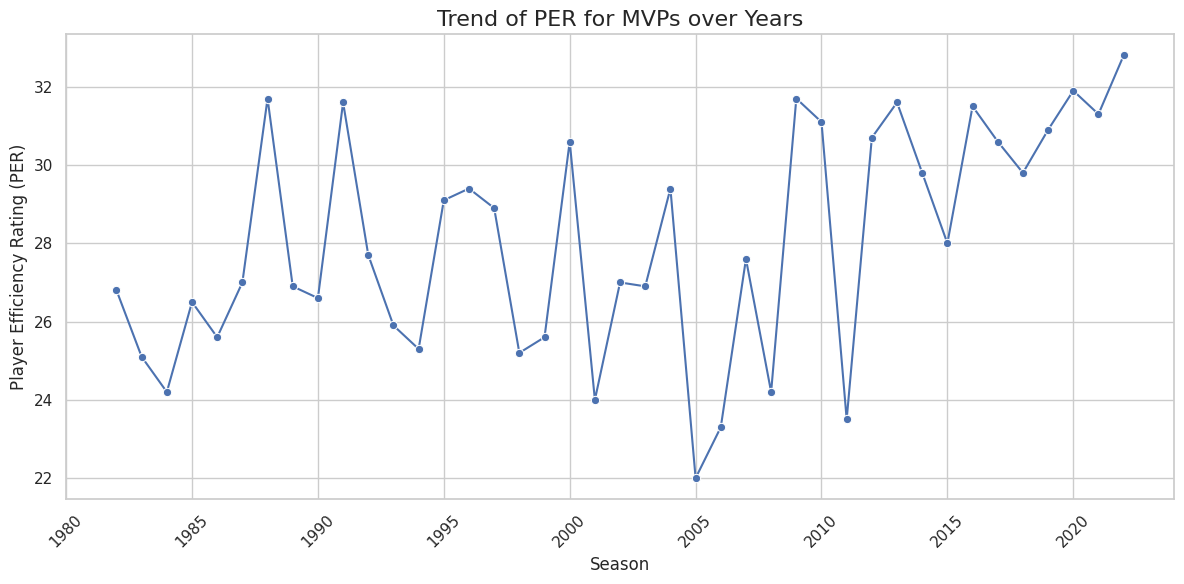

In [ ]:
# plot 1
sns.set(style = 'whitegrid')

mvp_per_trend = mvp_data.groupby('season')['per'].mean()

plt.figure(figsize = (12,6))
sns.lineplot( x = mvp_per_trend.index,
              y = mvp_per_trend.values,
              color = 'b',
              marker = 'o')

plt.title('Trend of PER for MVPs over Years', fontsize = 16)
plt.xlabel('Season', fontsize = 12)
plt.ylabel('Player Efficiency Rating (PER)', fontsize = 12)

plt.xticks(rotation = 45)
plt.tight_layout()

plt.show()

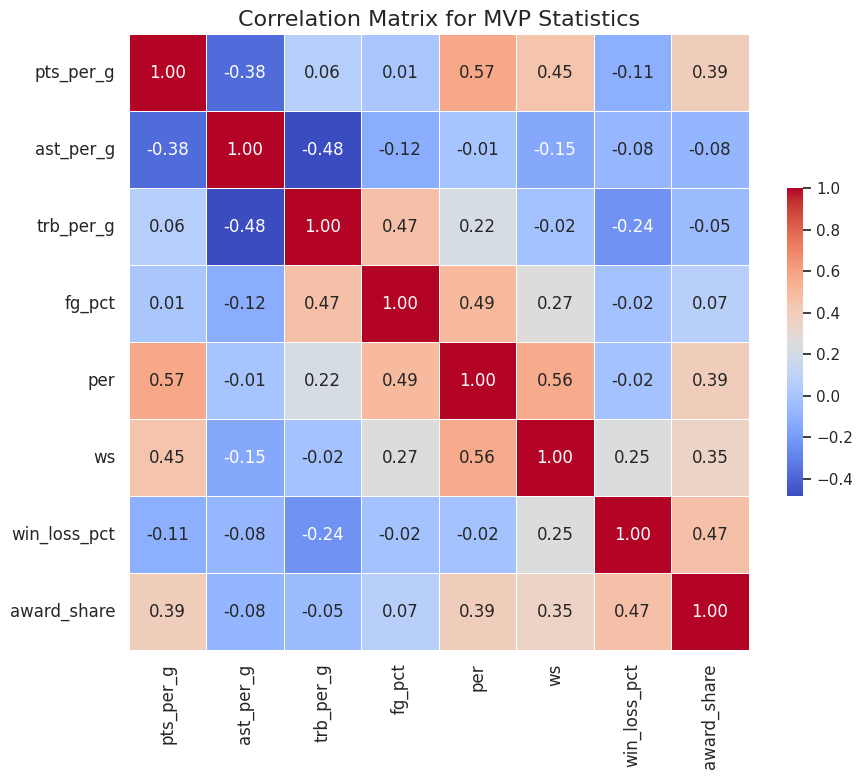

In [ ]:
# plot 2
sns.set(style="white")

stats_for_correlation = mvp_data[['pts_per_g', 'ast_per_g', 'trb_per_g',
                                  'fg_pct', 'per', 'ws', 'win_loss_pct',
                                  'award_share']]
corr = stats_for_correlation.corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5, cmap="coolwarm", cbar_kws={'shrink': .5})

plt.title('Correlation Matrix for MVP Statistics', fontsize=16)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 12)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 12)

plt.show()

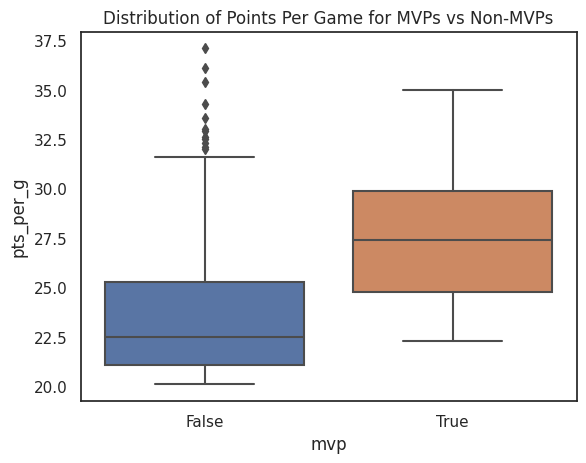

In [ ]:
# plot 3

sns.boxplot(x='mvp', y='pts_per_g', data=data)
plt.title('Distribution of Points Per Game for MVPs vs Non-MVPs')
plt.show()


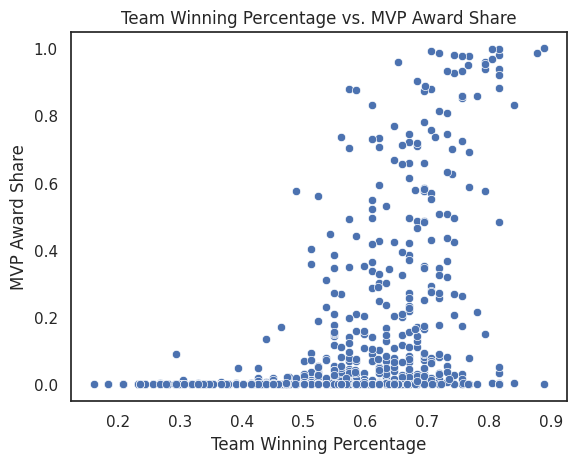

In [ ]:
sns.scatterplot(x='win_loss_pct', y='award_share', data=data)
plt.title('Team Winning Percentage vs. MVP Award Share')
plt.xlabel('Team Winning Percentage')
plt.ylabel('MVP Award Share')
plt.show()

In [ ]:
# To continue further prediction, we need to drop some irrelevant information from EDA

data = data.drop(columns = ["season", "player", "award_share"], axis = 1)

In [ ]:
# Split the dataset into train and test in a 8:2 ratio

from sklearn.model_selection import train_test_split

X = data.drop('mvp', axis = 1)
y = data['mvp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.head()

,age,gs,mp_per_g,fg_pct,fg3_pct,fg2_pct,ft_pct,trb_per_g,ast_per_g,stl_per_g,...,dws,ws,ws_per_48,obpm,dbpm,bpm,vorp,mov,mov_adj,win_loss_pct
14574,27,74,35.4,0.467,0.266,0.484,0.842,5.2,3.9,1.1,...,2.4,9.0,0.166,4.1,-1.0,3.0,3.3,4.21,3.65,0.622
16713,23,58,35.1,0.477,0.322,0.539,0.719,3.5,7.2,1.5,...,0.8,4.2,0.098,3.1,-1.3,1.8,2.0,-3.68,-3.45,0.431
448,26,80,35.7,0.509,0.200,0.514,0.735,7.0,4.5,1.3,...,4.1,10.7,0.180,4.2,0.4,4.5,4.7,4.40,4.32,0.622
417,24,76,36.2,0.484,0.288,0.502,0.679,3.9,3.5,1.8,...,2.2,2.8,0.048,0.2,-1.1,-0.9,0.8,-4.20,-4.22,0.366
13350,35,80,32.9,0.497,0.398,0.532,0.899,6.2,2.7,0.9,...,2.3,10.9,0.199,5.0,0.0,5.0,4.7,2.40,2.90,0.598


In [ ]:
# Random Forest

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state = 42))
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9591836734693877
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       186
        True       0.62      0.50      0.56        10

    accuracy                           0.96       196
   macro avg       0.80      0.74      0.77       196
weighted avg       0.96      0.96      0.96       196

